In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from scdna_replication_tools.plot_utils import get_metacohort_cmaps, get_metacohort_feature_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 5
despine_trim = True

In [3]:
# load the features which contain the metadata for all clones included in the metacohort
df = pd.read_csv('../../analysis/rt_model/features.csv.gz')
table = pd.read_csv('../../data/rt_model_metacohort.tsv', sep='\t')
df.head()

,clone_id,num_cells_s,num_cells_g,dataset,frac_cells_s,frac_cells_g,ploidy,condition,type_GM18507,type_HGSOC,type_OV2295,type_T47D,type_TNBC,type_hTERT,signature_FBI,signature_HRD,signature_TD
0,A,663.0,1159.0,SA039,0.488578,0.794925,2.0,Line,0,0,0,0,0,1,0,0,0
1,B,453.0,165.0,SA039,0.333825,0.113169,2.0,Line,0,0,0,0,0,1,0,0,0
2,C,209.0,129.0,SA039,0.154016,0.088477,2.0,Line,0,0,0,0,0,1,0,0,0
3,D,32.0,5.0,SA039,0.023581,0.003429,2.0,Line,0,0,0,0,0,1,0,0,0
4,A,103.0,47.0,SA906a,0.075292,0.064384,2.0,Line,0,0,0,0,0,1,0,0,0


In [4]:
# drop all the one-hot-encoded columns from df that begin with type_ or signature_ 
df = df.loc[:,~df.columns.str.startswith('type_')]
df = df.loc[:,~df.columns.str.startswith('signature_')]

# drop the cn_path and rt_path columns from table
table = table.drop(['cn_path', 'rt_path', 'condition'], axis=1)

# merge the two dataframes on the dataset column
df = df.merge(table, on='dataset')

# convert the num_cells_s and num_cells_g columns to ints and sum them to get the total number of cells
df['num_cells_s'] = df['num_cells_s'].astype(int)
df['num_cells_g'] = df['num_cells_g'].astype(int)
df['num_cells'] = df['num_cells_s'] + df['num_cells_g']

df.head()

,clone_id,num_cells_s,num_cells_g,dataset,frac_cells_s,frac_cells_g,ploidy,condition,type,signature,num_cells
0,A,663,1159,SA039,0.488578,0.794925,2.0,Line,hTERT,NaN,1822
1,B,453,165,SA039,0.333825,0.113169,2.0,Line,hTERT,NaN,618
2,C,209,129,SA039,0.154016,0.088477,2.0,Line,hTERT,NaN,338
3,D,32,5,SA039,0.023581,0.003429,2.0,Line,hTERT,NaN,37
4,A,103,47,SA906a,0.075292,0.064384,2.0,Line,hTERT,NaN,150


In [5]:
df.shape

(102, 11)

In [6]:
cell_type_cmap, signature_cmap, condition_cmap, ploidy_cmap, sample_cmap = get_metacohort_cmaps()
cell_type_cdict, signature_cdict, condition_cdict, ploidy_cdict, sample_cdict = get_metacohort_cmaps(return_cdicts=True)
feature_cmap = get_metacohort_feature_cmap()

In [7]:
df['ploidy'].astype(int).value_counts()

2    66
3    23
4    12
5     1
Name: ploidy, dtype: int64

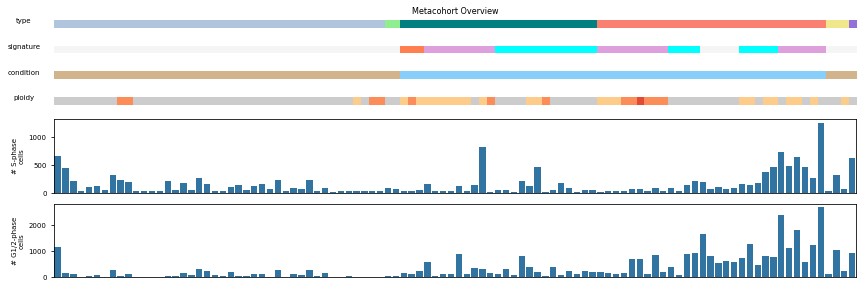

In [8]:
# create a multipanel figure that shows the distribution of the metadata for each dataset
# each column is a different dataset
# the first row shows the 'type' as an annotated colorbar
# the second row shows the 'signature' as an annotated colorbar
# the third row shows the 'condition' as an annotated colorbar
# the fourth row shows 'ploidy' as a heatmap
# the fifth row shows 'num_cells_s' as a barplot
# the sixth row shows 'num_cells_g' as a barplot
# the x-axis labels are the dataset names

# create a figure with 6 rows and 1 column of size 12x4
# have the first 4 rows be half the size as the last 2 rows
fig, ax = plt.subplots(6, 1, figsize=(12, 4), sharex=True, tight_layout=True, gridspec_kw={'height_ratios': [0.2, 0.2, 0.2, 0.2, 1, 1]})

# compress the subplots so that there is no space between them
plt.subplots_adjust(hspace=0)

# first row
# plot the type as a colorbar where each value corresponds to a different color
ax[0].imshow(df['type'].map({'hTERT': 0, 'HGSOC': 1, 'TNBC': 2, 'OV2295': 3, 'T47D': 4, 'GM18507': 5}).to_frame().T, cmap=cell_type_cmap) 
# remove the ytick labels
ax[0].set_yticklabels([])
ax[0].set_yticks([])
# set a y-axis label
ax[0].set_ylabel('type', rotation=0, labelpad=30)

# second row
temp_signature_cdict = {0: signature_cdict[0], 1: signature_cdict[1], 2: signature_cdict[2], 3: signature_cdict[3]}
temp_signature_cmap = LinearSegmentedColormap.from_list('signature_cmap', list(temp_signature_cdict.values()), N=len(temp_signature_cdict))
ax[1].imshow(df['signature'].map({'FBI': 0, 'HRD': 1, 'TD': 2, np.nan: 3}).to_frame().T, cmap=temp_signature_cmap)
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_ylabel('signature', rotation=0, labelpad=30)

# third row
ax[2].imshow(df['condition'].map({'Line': 0, 'PDX': 1}).to_frame().T, cmap=condition_cmap)
ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[2].set_ylabel('condition', rotation=0, labelpad=30)

# fourth row
ax[3].imshow(df['ploidy'].astype(int).to_frame().T, cmap=ploidy_cmap)
ax[3].set_yticklabels([])
ax[3].set_yticks([])
ax[3].set_ylabel('ploidy', rotation=0, labelpad=30)

# fifth row
# the x-axis is the index of the dataframe
sns.barplot(x=df.index, y='num_cells_s', data=df, ax=ax[4], color='tab:blue')
ax[4].set_ylabel('# S-phase\ncells')

# sixth row
sns.barplot(x=df.index, y='num_cells_g', data=df, ax=ax[5], color='tab:blue')
ax[5].set_ylabel('# G1/2-phase\ncells')

# remove the subplot borders from the first 4 rows
for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

# remove the xtick labels from all rows
for i in range(6):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])

# set a title for the entire figure
ax[0].set_title('Metacohort Overview')

# fig.savefig('../../plots/rt_model/main_fig_draft_metacohort_overview.pdf', bbox_inches='tight')

plt.show()

### Make a draft of the main figure that just shows the metacohort overview in panel A

In [9]:
def plot_metacohort_overview(df, ax_type, ax_sig, ax_ploidy, ax_cond, ax_sample, ax_s):
    # first row
    # plot the type as a colorbar where each value corresponds to a different color
    ax_type.imshow(df['type'].map({'hTERT': 0, 'HGSOC': 1, 'TNBC': 2, 'OV2295': 3, 'T47D': 4, 'GM18507': 5}).to_frame().T, cmap=cell_type_cmap) 
    # set a y-axis label
    ax_type.set_ylabel('type', rotation=0, labelpad=30)

    # second row
    temp_signature_cdict = {0: signature_cdict[0], 1: signature_cdict[1], 2: signature_cdict[2], 3: signature_cdict[3]}
    temp_signature_cmap = LinearSegmentedColormap.from_list('signature_cmap', list(temp_signature_cdict.values()), N=len(temp_signature_cdict))
    ax_sig.imshow(df['signature'].map({'FBI': 0, 'HRD': 1, 'TD': 2, np.nan: 3}).to_frame().T, cmap=temp_signature_cmap)
    ax_sig.set_ylabel('signature', rotation=0, labelpad=30)

    # third row
    ax_cond.imshow(df['condition'].map({'Line': 0, 'PDX': 1}).to_frame().T, cmap=condition_cmap)
    ax_cond.set_ylabel('condition', rotation=0, labelpad=30)

    # fourth row
    ax_ploidy.imshow(df['ploidy'].astype(int).to_frame().T, cmap=ploidy_cmap)
    ax_ploidy.set_ylabel('ploidy', rotation=0, labelpad=30)

    # fifth row
    # TODO: create the appropriate map from sample_id to integers
    ax_sample.imshow(df['dataset'].map(df[['dataset']].drop_duplicates().reset_index(drop=True).reset_index().set_index('dataset').to_dict()['index']).to_frame().T, cmap=sample_cmap)
    ax_sample.set_ylabel('sample', rotation=0, labelpad=30)

    # sixth row
    # the x-axis is the index of the dataframe
    sns.barplot(x=df.index, y='num_cells_s', data=df, ax=ax_s, color='tab:blue')
    ax_s.set_ylabel('# S-phase\ncells')
    # log10 scale this axis
    ax_s.set_yscale('log')

    # # seventh row
    # sns.barplot(x=df.index, y='num_cells_g', data=df, ax=ax_g, color='tab:blue')
    # ax_g.set_ylabel('# G1/2-phase\ncells')

    # remove the subplot borders from the first 4 rows
    # also remove y-axis ticks and tick labels
    for ax in [ax_type, ax_sig, ax_cond, ax_ploidy, ax_sample]:
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # remove the xtick labels from all rows
    for ax in [ax_s]:
        sns.despine(ax=ax)
        ax.set_xticklabels([])
        ax.set_xticks([])
    num_clones = int(df.shape[0])
    ax_s.set_xlabel('{} clones'.format(num_clones))
    


### Load and plot data showing the distribution of cell S-phase times for all samples in the metacohort

In [10]:
pdxs = [
    'SA1047',
    'SA1049',
    'SA1050',
    'SA1051',
    'SA1052',
    'SA1053',
    'SA1093',
    'SA1096',
    'SA1181',
    'SA1182',
    'SA1184',
    'SA501',
    'SA530',
    'SA604',
]

cell_lines = [
    'OV2295',
    'SA039',
    'SA1054',
    'SA1055',
    'SA1056',
    'SA1188',
    'SA1292',
    'SA906a',
    'SA906b',
]

cell_frac_rep = []

for dataset in pdxs:
    filename = f'/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/sig_tumors/{dataset}/s_phase_cells_with_scRT_filtered.csv.gz'
    cell_frac_rep.append(pd.read_csv(filename, usecols=['cell_id', 'clone_id', 'cell_frac_rep']).drop_duplicates(['cell_id', 'clone_id']).assign(dataset=dataset))

for dataset in cell_lines:
    filename = f'/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/sig_lines/{dataset}/s_phase_cells_with_scRT_filtered.tsv'
    cell_frac_rep.append(pd.read_csv(filename, sep='\t', usecols=['cell_id', 'clone_id', 'cell_frac_rep']).drop_duplicates(['cell_id', 'clone_id']).assign(dataset=dataset))

filename = '/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/laks_flow/GM18507/cn_s_pyro_inferred_composite_filtered.tsv'
cell_frac_rep.append(pd.read_csv(filename, sep='\t', usecols=['cell_id', 'clone_id', 'cell_frac_rep']).drop_duplicates(['cell_id', 'clone_id']).assign(dataset='GM18507'))

filename = '/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/laks_flow/T47D/cn_s_pyro_inferred_composite_filtered.tsv'
cell_frac_rep.append(pd.read_csv(filename, sep='\t', usecols=['cell_id', 'clone_id', 'cell_frac_rep']).drop_duplicates(['cell_id', 'clone_id']).assign(dataset='T47D'))

cell_frac_rep = pd.concat(cell_frac_rep)

In [11]:

features = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/features.csv.gz', low_memory=False)

features['clone'] = features['dataset'] + '_clone' + features['clone_id']
features = features.set_index('clone')
features['signature_NA'] = 1 - features.filter(regex='signature_.*', axis=1).sum(axis=1)
features['wgd'] = (features['ploidy'] > 2) * 1

features_ploidy = features['ploidy'].astype('int').astype('str').to_frame()

features_wgd = features['wgd'].to_frame()

features_signature = features.filter(regex='signature_.*', axis=1).melt(var_name='signature', value_name='indicator', ignore_index=False)
features_signature = features_signature[features_signature['indicator'] == 1]
features_signature['signature'] = features_signature['signature'].str.replace('signature_', '')
features_signature = features_signature.drop('indicator', axis=1)

features_type = features.filter(regex='type_.*', axis=1).melt(var_name='type', value_name='indicator', ignore_index=False)
features_type = features_type[features_type['indicator'] == 1]
features_type['type'] = features_type['type'].str.replace('type_', '')
features_type = features_type.drop('indicator', axis=1)

features_df = pd.concat([features_type, features_signature, features_ploidy, features_wgd], axis=1).fillna('N/A')
features_df.index.name = 'clone'

cell_frac_rep['clone'] = cell_frac_rep['dataset'] + '_clone' + cell_frac_rep['clone_id']


In [12]:

cell_frac_rep = cell_frac_rep.merge(features_df.reset_index())
cell_frac_rep


,cell_id,clone_id,cell_frac_rep,dataset,clone,type,signature,ploidy,wgd
0,SA1049AX1XB01417-A96205B-R47-C07,G,0.452761,SA1049,SA1049_cloneG,HGSOC,FBI,3,1
1,SA1049AX1XB01417-A96205B-R53-C15,G,0.849202,SA1049,SA1049_cloneG,HGSOC,FBI,3,1
2,SA1049AX1XB01417-A96205B-R54-C09,G,0.788663,SA1049,SA1049_cloneG,HGSOC,FBI,3,1
3,SA1049AX1XB01417-A96205B-R58-C34,G,0.107503,SA1049,SA1049_cloneG,HGSOC,FBI,3,1
4,SA1049AX1XB01417-A96205B-R63-C43,G,0.585581,SA1049,SA1049_cloneG,HGSOC,FBI,3,1
...,...,...,...,...,...,...,...,...,...
10291,SA1044-A96139A-R40-C46,D,0.943134,T47D,T47D_cloneD,T47D,NA,3,1
10292,SA1044-A96147A-R06-C49,D,0.941423,T47D,T47D_cloneD,T47D,NA,3,1
10293,SA1044-A96147A-R10-C40,D,0.902625,T47D,T47D_cloneD,T47D,NA,3,1
10294,SA1044-A96147A-R26-C44,D,0.939711,T47D,T47D_cloneD,T47D,NA,3,1


In [13]:
cell_frac_rep.clone.unique()

array(['SA1049_cloneG', 'SA1049_cloneH', 'SA1049_cloneI', 'SA1049_cloneC',
       'SA1049_cloneA', 'SA1049_cloneB', 'SA1050_cloneA', 'SA1050_cloneH',
       'SA1051_cloneB', 'SA1051_cloneA', 'SA1052_cloneC', 'SA1052_cloneB',
       'SA1053_cloneE', 'SA1053_cloneD', 'SA1053_cloneA', 'SA1053_cloneB',
       'SA1093_cloneD', 'SA1093_cloneA', 'SA1093_cloneC', 'SA1096_cloneG',
       'SA1096_cloneB', 'SA1096_cloneA', 'SA1181_cloneF', 'SA1184_cloneA',
       'SA1184_cloneC', 'SA501_cloneA', 'SA501_cloneG', 'SA501_cloneD',
       'SA501_cloneB', 'SA530_cloneB', 'SA530_cloneC', 'SA530_cloneA',
       'SA604_cloneM', 'SA604_cloneK', 'SA604_cloneN', 'SA604_cloneA',
       'SA604_cloneC', 'SA604_cloneO', 'OV2295_cloneC', 'OV2295_cloneB',
       'SA039_cloneC', 'SA039_cloneB', 'SA039_cloneA', 'SA039_cloneD',
       'SA1054_cloneA', 'SA1054_cloneB', 'SA1054_cloneE', 'SA1054_cloneC',
       'SA1055_cloneI', 'SA1056_cloneA', 'SA1056_cloneB', 'SA1188_cloneG',
       'SA1188_cloneB', 'SA1188_cloneD', '

In [14]:

def plot_s_phase_times(cell_frac_rep, features, ax_sig, ax_wgd):
    '''
    Plot the S-phase times for each clone split by signature and WGD status
    Uses the cell_frac_rep dataframe and the features dataframe
    '''
    plot_data = cell_frac_rep
    # remove = []
    # plot_data = plot_data[~plot_data['clone'].isin(remove)]
    plot_data = plot_data.merge(features.reset_index()[['clone', 'num_cells_s']])
    plot_data['clone'] = plot_data['clone'] + ' n_s=' + plot_data['num_cells_s'].astype(str)
    plot_data = plot_data[plot_data['num_cells_s'] >= 20]

    # plot a barplot of S-phase times split by signature with p-value annotations
    sig_order = ['NA', 'HRD', 'FBI', 'TD']
    sns.barplot(ax=ax_sig, data=plot_data, x='signature', y='cell_frac_rep', color='C0', order=sig_order)
    add_stat_annotation(
        ax_sig, plot='boxplot', data=plot_data, x='signature', y='cell_frac_rep', order=sig_order,
        box_pairs = [('FBI', 'HRD'), ('FBI', 'TD'), ('HRD', 'TD'), ('FBI', 'NA'), ('HRD', 'NA'), ('TD', 'NA')],
        test='t-test_ind'
    )
    ax_sig.set_yticks([0, 0.5, 1])
    ax_sig.set_ylabel('<-- early S | late S -->')
    ax_sig.set_title('S-phase cell times')
    sns.despine(ax=ax_sig, trim=True)

    # plot a barplot of S-phase times split by WGD with p-value annotations
    plot_data['WGD'] = plot_data['wgd'].replace({0: 'NGD', 1: 'WGD'})
    wgd_order = ['NGD', 'WGD']
    sns.barplot(ax=ax_wgd, data=plot_data, x='WGD', y='cell_frac_rep', color='C0', order=wgd_order)
    add_stat_annotation(
        ax_wgd, plot='boxplot', data=plot_data, x='WGD', y='cell_frac_rep', order=wgd_order,
        box_pairs = [('NGD', 'WGD')],
        test='t-test_ind', text_format='full'
    )
    ax_wgd.set_yticks([0, 0.5, 1])
    ax_wgd.set_ylabel('<-- early S | late S -->')
    ax_wgd.set_xlabel('ploidy')
    sns.despine(ax=ax_wgd, trim=True)


### Load and plot the beta importance terms from the pyro model of clone RT

In [15]:
betas = pd.read_csv('../../analysis/rt_model/beta_importance_posteriors_v2.csv.gz')

In [16]:
betas.head()

,beta_cell_type_importance,beta_signature_importance,beta_wgd_importance,beta_dataset_importance,beta_global_rt_importance
0,23.609682,1.694000,2.107487,30.101997,98.749050
1,24.700810,1.436369,2.033729,29.913837,96.768720
2,24.739560,1.522934,2.313613,30.226645,97.139170
3,24.143630,1.614529,2.053557,29.868889,96.978714
4,24.652754,1.456153,1.939701,30.455488,96.702350


In [17]:
betas_df = betas.rename(columns={'beta_cell_type_importance': 'type', 'beta_signature_importance': 'signature', 'beta_wgd_importance': 'ploidy', 'beta_dataset_importance': 'sample', 'beta_global_rt_importance': 'global'}).melt(id_vars=None, value_vars=['type', 'signature', 'ploidy', 'sample', 'global'], var_name='feature', value_name='importance')
betas_df.head()

,feature,importance
0,type,23.609682
1,type,24.700810
2,type,24.739560
3,type,24.143630
4,type,24.652754


In [18]:
def plot_beta_importance_posteriors(betas, ax, title='Clone RT regression\nfeature importance', palette=None):
    '''
    plot a barplot of the mean beta importance for each feature
    each column has its own bar and color
    '''
    # plot a barplot of S-phase times split by signature with p-value annotations
    order = ['global', 'sample', 'type', 'ploidy', 'signature']
    if palette is None:
        sns.barplot(ax=ax, data=betas, x='feature', y='importance', color='C0', order=order)
    else:
        sns.barplot(ax=ax, data=betas, x='feature', y='importance', palette=palette, order=order)
    ax.set_ylabel('mean beta (95% CI)')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(title)
    sns.despine(ax=ax, trim=True)
    
    add_stat_annotation(
        ax, plot='boxplot', data=betas, x='feature', y='importance', order=order,
        box_pairs = [('global', 'sample'), ('sample', 'type'), ('type', 'ploidy'), ('ploidy', 'signature')],
        test='t-test_ind'
    )
    


### Load and plot data showing the cell type mean RT for chromosomes 1, 2, and X across the metacohort along with select ENCODE cell line RepliSeq data

In [19]:
def load_encode_repliseq():
    columns = [
        'chr',
        'start',
        'end',
        'mcf7_rt',
        'bg02es_rt',
        'bj_rt',
        'gm06990_rt',
        'gm12801_rt',
        'gm12812_rt',
        'gm12813_rt',
        'gm12878_rt',
        'helas3_rt',
        'hepg2_rt',
        'huvec_rt',
        'imr90_rt',
        'k562_rt',
        'sknsh_rt',
        'nhek_rt',
    ]

    encode_filename = '/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/simulation/D1.0/s_phase_cells_pyro_composite_filtered.tsv'
    encode = pd.read_csv(encode_filename, sep='\t', low_memory=True, usecols=columns).drop_duplicates()
    encode['start'] += 1
    encode = encode.set_index(['chr', 'start', 'end']).T
    
    return encode


def load_clone_rt_and_features(remove=[]):
    clone_rt = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/clone_rt.csv.gz', low_memory=False)
    features = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/rt_model/features.csv.gz', low_memory=False)

    features['clone'] = features['dataset'] + '_clone' + features['clone_id']
    features = features.set_index('clone')
    features['signature_NA'] = 1 - features.filter(regex='signature_.*', axis=1).sum(axis=1)
    features['wgd'] = (features['ploidy'] > 2) * 1

    clone_rt = clone_rt.set_index(['chr', 'start', 'end']).T
    clone_rt.index = [a.replace('pseudobulk_', '').replace('_model_rep_state', '') for a in clone_rt.index]

    # filter based on the remove list
    clone_rt = clone_rt[~clone_rt.index.isin(remove)]
    features = features.reindex(clone_rt.index)

    # filter based on the number of cells
    features = features[features['num_cells_s'] >= 20]
    clone_rt = clone_rt.reindex(features.index)

    # create the full features dataframe
    # ploidy
    features_ploidy = features['ploidy'].astype('int').astype('str').to_frame()
    # wgd
    features_wgd = features['wgd'].to_frame()
    # signature
    assert (features.filter(regex='signature_.*', axis=1).sum(axis=1) == 1).all()
    features_signature = features.filter(regex='signature_.*', axis=1).melt(var_name='signature', value_name='indicator', ignore_index=False)
    features_signature = features_signature[features_signature['indicator'] == 1]
    features_signature['signature'] = features_signature['signature'].str.replace('signature_', '')
    features_signature = features_signature.drop('indicator', axis=1)
    features_signature = features_signature.reindex(clone_rt.index, fill_value='NA')
    # cell type
    features_type = features.filter(regex='type_.*', axis=1).melt(var_name='type', value_name='indicator', ignore_index=False)
    features_type = features_type[features_type['indicator'] == 1]
    features_type['type'] = features_type['type'].str.replace('type_', '')
    features_type = features_type.drop('indicator', axis=1)
    # dataset
    features_dataset = features['dataset'].to_frame()

    # combine all features
    features_df = pd.concat([features_type, features_signature, features_dataset, features_ploidy, features_wgd], axis=1).fillna('N/A')
    features_df.index.name = 'clone'

    return clone_rt, features_df


def load_combined_rt(remove=[]):
    encode = load_encode_repliseq()
    clone_rt, features_df = load_clone_rt_and_features(remove=remove)
    merged_index = encode.columns.intersection(clone_rt.columns)
    combined = pd.concat([
        encode.loc[:, merged_index],
        clone_rt.loc[:, merged_index],
    ], axis=0)
    return combined, features_df


In [20]:
combined, feature_df2 = load_combined_rt()
combined.head()

chr                 1                                                         \
start       2000001    4500001    6500001    7500001    9500001    10000001    
end         2500000    5000000    7000000    8000000    10000000   10500000    
mcf7_rt     78.557313  30.079553  74.903479  67.815372  77.181738  75.056363   
bg02es_rt   68.242313  23.940442  67.906083  46.320877  69.905239  74.022530   
bj_rt       72.627731  22.735442  69.687254  57.355192  73.122724  73.454316   
gm06990_rt  66.228156  21.389899  68.408049  44.725611  77.365337  73.655181   
gm12801_rt  65.943010  24.517347  66.234313  49.245544  70.756706  68.592534   

chr                                                     ...          X  \
start       10500001   12000001   12500001   19000001   ...  144500001   
end         11000000   12500000   13000000   19500000   ...  145000000   
mcf7_rt     74.383960  70.662802  65.132429  69.401959  ...  13.557438   
bg02es_rt   70.087718  69.841477  58.234421  60.051422  ...  24.475248   
bj_rt       65.251409  70.017019  59.681516  67.157811  ...  15.063278   
gm06990_rt  71.064673  78.137663  57.458716  60.258719  ...  10.040736   
gm12801_rt  67.689140  71.493997  55.938872  59.491423  ...  15.602451   

chr                                                                           \
start       145000001  145500001  147000001  150000001  151000001  152500001   
end         145500000  146000000  147500000  150500000  151500000  153000000   
mcf7_rt     11.422099  13.727174  17.298807  49.542440  21.642373  66.362452   
bg02es_rt   18.245038  16.461949  38.704279  55.291167  22.473460  53.574604   
bj_rt       15.550001  15.737970  18.913662  41.576116  36.880595  65.808882   
gm06990_rt  11.591476  10.383099  19.292671  32.879295  16.160199  35.412800   
gm12801_rt  14.964384  16.151959  31.618535  44.995246  19.637931  57.256598   

chr                                          
start       153500001  154000001  154500001  
end         154000000  154500000  155000000  
mcf7_rt     75.837731  61.508320  50.075926  
bg02es_rt   72.612155  54.118303  35.139065  
bj_rt       74.515786  49.752168  31.826692  
gm06990_rt  47.109864  47.758362  36.458215  
gm12801_rt  73.121403  62.746530  47.850595  

[5 rows x 2975 columns]

In [21]:
combined.index

Index(['mcf7_rt', 'bg02es_rt', 'bj_rt', 'gm06990_rt', 'gm12801_rt',
       'gm12812_rt', 'gm12813_rt', 'gm12878_rt', 'helas3_rt', 'hepg2_rt',
       ...
       'SA609_cloneF', 'SA535_cloneA', 'SA535_cloneB', 'SA535_cloneC',
       'SA535_cloneD', 'SA535_cloneE', 'T47D_cloneA', 'T47D_cloneC',
       'T47D_cloneD', 'GM18507_cloneA'],
      dtype='object', length=117)

['bj_rt' 'gm12878_rt' 'OV2295' 'hTERT' 'HGSOC' 'TNBC' 'T47D' 'GM18507']


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


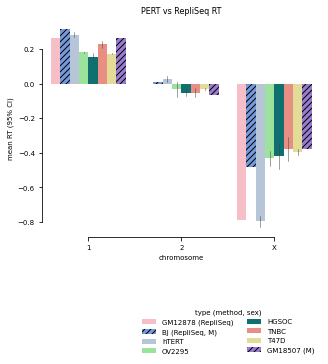

In [22]:
def rt_by_chrom_and_type_example(combined, features_df, ax=None):
    
    Y = combined.copy()
    scaler = StandardScaler()
    Y.values[:] = scaler.fit_transform(Y.T).T

    chromosomes = [str(a) for a in range(1, 23)] + ['X']
    chromosomes = ['1', '2', 'X']
    width = 20
    width = 5

    plot_data = Y.T.groupby(level=0).mean().melt(ignore_index=False, var_name='clone', value_name='mean_rt').reset_index()
    plot_data = plot_data.merge(features_df.reset_index(), how='left')
    plot_data.loc[plot_data['clone'].str.endswith('_rt'), 'type'] = plot_data.loc[plot_data['clone'].str.endswith('_rt'), 'clone']

    # plt.figure(figsize=(width, 4))
    # sns.barplot(x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data, palette='tab10')
    # # plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(1., 1.), title='type')
    # sns.despine()
    # plt.show()

    plot_data2 = plot_data[~plot_data['clone'].str.endswith('_rt')]

    # plt.figure(figsize=(width, 4))
    # sns.barplot(x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data2, palette='tab10')
    # # plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(1., 1.), title='type')
    # sns.despine()
    # plt.show()

    plot_data2 = plot_data[plot_data['clone'].str.endswith('_rt')]
    plot_data2 = plot_data[
        # (plot_data['clone'] == 'mcf7_rt') |
        # (plot_data['clone'] == 'helas3_rt') |
        # (plot_data['clone'] == 'k562_rt') |
        (plot_data['clone'] == 'gm12878_rt') |
        (plot_data['clone'] == 'bj_rt') |
        (~plot_data['clone'].str.endswith('_rt'))]

    print(plot_data2['type'].unique())

    plot_data2['type'] = plot_data2['type'].str.replace('_rt', ' (RepliSeq)')
    # for all type entries that don't end in (RepliSeq), add (PERT) to the end
    # plot_data2.loc[~plot_data2['type'].str.endswith(' (RepliSeq)'), 'type'] = plot_data2.loc[~plot_data2['type'].str.endswith(' (RepliSeq)'), 'type'] + ' (PERT)'

    plot_data2.loc[plot_data2['type'] == 'bj (RepliSeq)', 'type'] = 'BJ (RepliSeq, M)'
    plot_data2.loc[plot_data2['type'] == 'gm12878 (RepliSeq)', 'type'] = 'GM12878 (RepliSeq)'

    # # replace bj type with BJ and add (M) to the end to denote that it's a male cell line
    # plot_data2.loc[plot_data2['type'] == 'bj (RepliSeq)', 'type'] = 'BJ (M, RepliSeq)'
    # # replace gm12878 type with GM12878 and add (F) to the end to denote that it's a female cell line
    # plot_data2.loc[plot_data2['type'] == 'gm12878 (RepliSeq)', 'type'] = 'GM12878 (F, RepliSeq)'
    # # add (F) to the end of cell types OV2295, hTERT, HGSOC, TNBC, and T47D
    # plot_data2.loc[plot_data2['type'] == 'OV2295 (PERT)', 'type'] = 'OV2295 (F, PERT)'
    # plot_data2.loc[plot_data2['type'] == 'hTERT (PERT)', 'type'] = 'hTERT (F, PERT)'
    # plot_data2.loc[plot_data2['type'] == 'HGSOC (PERT)', 'type'] = 'HGSOC (F, PERT)'
    # plot_data2.loc[plot_data2['type'] == 'TNBC (PERT)', 'type'] = 'TNBC (F, PERT)'
    # plot_data2.loc[plot_data2['type'] == 'T47D (PERT)', 'type'] = 'T47D (F, PERT)'
    # # add (M) to the end of cell types GM18507
    plot_data2.loc[plot_data2['type'] == 'GM18507', 'type'] = 'GM18507 (M)'

    palette = {
        'BJ (RepliSeq, M)': 'cornflowerblue',
        'GM12878 (RepliSeq)': 'lightpink',
        'OV2295': 'lightgreen',
        'hTERT': 'lightsteelblue',
        'HGSOC': 'teal',
        'TNBC': 'salmon',
        'T47D': 'khaki',
        'GM18507 (M)': 'mediumpurple',
    }

    hue_order = [
        'GM12878 (RepliSeq)',
        'BJ (RepliSeq, M)',
        'hTERT',
        'OV2295',
        'HGSOC',
        'TNBC',
        'T47D',
        'GM18507 (M)',
    ]

    # use hatch patterns to denote which cell types are from RepliSeq and which are from PERT
    hatches =  [
        '',
        '////',
        '',
        '',
        '',
        '',
        '',
        '////'
    ]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(width, 4))
    ax = sns.barplot(ax=ax, x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data2, palette=palette, hue_order=hue_order, errwidth=0.5)

    # add hatches
    for bars, hatch in zip(ax.containers, hatches):
        for bar in bars:
            bar.set_hatch(hatch)
    
    
    # move the legend below the plot
    ax.legend(loc='upper right', bbox_to_anchor=(1., -0.3), title='type (method, sex)', ncol=2, frameon=False)
    # ax.legend(title='cell type (sex, method)')
    ax.set_xlabel('chromosome')
    ax.set_ylabel('mean RT (95% CI)')
    ax.set_title('PERT vs RepliSeq RT')
    sns.despine(ax=ax, trim=True)

    # plot_data2 = plot_data[(plot_data['clone'] == 'mcf7_rt') | (~plot_data['clone'].str.endswith('_rt'))]

    # plt.figure(figsize=(width, 4))
    # sns.barplot(x='chr', hue='type', y='mean_rt', order=chromosomes, data=plot_data2, palette='tab10')
    # # plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(1., 1.), title='type')
    # sns.despine()
    # plt.show()


rt_by_chrom_and_type_example(combined, feature_df2)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HRD v.s. FBI: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-5.542e-01
FBI v.s. TD: t-test independent samples with Bonferroni correction, P_val=3.332e-02 stat=-2.776e+00
NA v.s. HRD: t-test independent samples with Bonferroni correction, P_val=1.333e-22 stat=-9.992e+00
HRD v.s. TD: t-test independent samples with Bonferroni correction, P_val=3.580e-02 stat=-2.753e+00
NA v.s. FBI: t-test independent samples with Bonferroni correction, P_val=9.756e-26 stat=-1.069e+01
NA v.s. TD: t-test independent samples with Bonferroni correction, P_val=7.024e-09 stat=-6.093e+00
NGD v.s. WGD: t-test independent samples with Bonferroni correction, P_val=1.147e-15 stat=-8.023e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv4/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


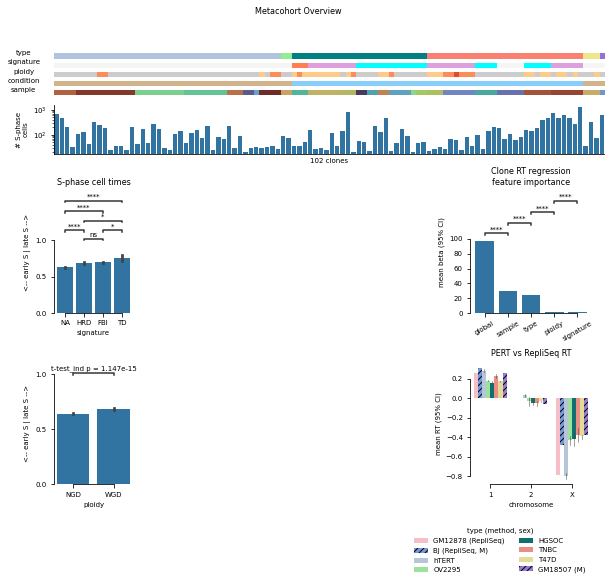

In [23]:
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))

fig.suptitle('Metacohort Overview')

# add four horizontal colorbars at the top to annotate cell type, signature, condition, and ploidy
ax0 = fig.add_axes([0.1, 0.895, 0.9, 0.01])
# ax0.set_title('ax0')
ax1 = fig.add_axes([0.1, 0.88, 0.9, 0.01], sharex=ax0)
# ax1.set_title('ax1')
ax2 = fig.add_axes([0.1, 0.865, 0.9, 0.01], sharex=ax0)
# ax2.set_title('ax2')
ax3 = fig.add_axes([0.1, 0.85, 0.9, 0.01], sharex=ax0)
# ax3.set_title('ax3')
ax4 = fig.add_axes([0.1, 0.835, 0.9, 0.01], sharex=ax0)

# add two barplots that align with the colorbars to show the number of cells in each phase
ax5 = fig.add_axes([0.1, 0.74, 0.9, 0.08], sharex=ax0)
# ax5.set_title('ax5')
# ax6 = fig.add_axes([0.1, 0.64, 0.9, 0.08], sharex=ax0)
# ax6.set_title('ax6')

# add two square axes on the left of the middle that are stacked vertically
# these will show cell S-phase times
ax7 = fig.add_axes([0.1, 0.48, 0.13, 0.2])
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.1, 0.2, 0.13, 0.2])

# add two square grids in the middle-right that should are stacked vertically
ax9 = fig.add_axes([0.78, 0.48, 0.2, 0.2])
# ax9.set_title('ax9')
ax10 = fig.add_axes([0.78, 0.2, 0.2, 0.2])


plot_metacohort_overview(df, ax0, ax1, ax2, ax3, ax4, ax5)

plot_s_phase_times(cell_frac_rep, features, ax7, ax8)

plot_beta_importance_posteriors(betas_df, ax9)

rt_by_chrom_and_type_example(combined, feature_df2, ax=ax10)

# # draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])


fig.savefig('../../manuscript/main_figs/fig4.pdf', dpi=300, bbox_inches='tight')

plt.show()